**ENTREGA FINAL**

***Grupo 8*** - Karen Baz, Federico Novelli

Importacion de librerias necesarias para este proyecto

In [44]:
import numpy as np
import pandas as pd
import statsmodels as st
import matplotlib.pyplot as plt
import statsmodels.api as sm           
import statsmodels.formula.api as smf  
import scipy as stast
import sklearn as skl         
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

Importacion de dataset

In [2]:
dataSet = pd.read_csv("heart_failure_clinical_records_dataset.csv")

In [3]:
dataSet.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


**Parte 1: EDA**

In [36]:
dataSet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  299 non-null    float64
 1   anaemia              299 non-null    int64  
 2   diabetes             299 non-null    int64  
 3   ejection_fraction    299 non-null    int64  
 4   high_blood_pressure  299 non-null    int64  
 5   platelets            299 non-null    float64
 6   serum_creatinine     299 non-null    float64
 7   serum_sodium         299 non-null    int64  
 8   sex                  299 non-null    int64  
 9   smoking              299 non-null    int64  
 10  time                 299 non-null    int64  
 11  DEATH_EVENT          299 non-null    int64  
dtypes: float64(3), int64(9)
memory usage: 28.2 KB


In [59]:
print(dataSet.isna().sum())

age                    0
anaemia                0
diabetes               0
ejection_fraction      0
high_blood_pressure    0
platelets              0
serum_creatinine       0
serum_sodium           0
sex                    0
smoking                0
time                   0
DEATH_EVENT            0
dtype: int64


No tenemos valores faltantes por lo que no es necesario hacer un Data Cleaning

In [58]:
100*dataSet['DEATH_EVENT'].value_counts()/len(dataSet['DEATH_EVENT'])

0    67.892977
1    32.107023
Name: DEATH_EVENT, dtype: float64

A partir del último calculo podemos ver que estamos frente a un set de datos fuertemente desbalanceado. Tenemos mas de dos tercios de personas que no han muerto que no fueron aprobados el seguro de vida. Clara señal de que el modelo de evaluación utilizado no es el indicado.

In [4]:
dataSet.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


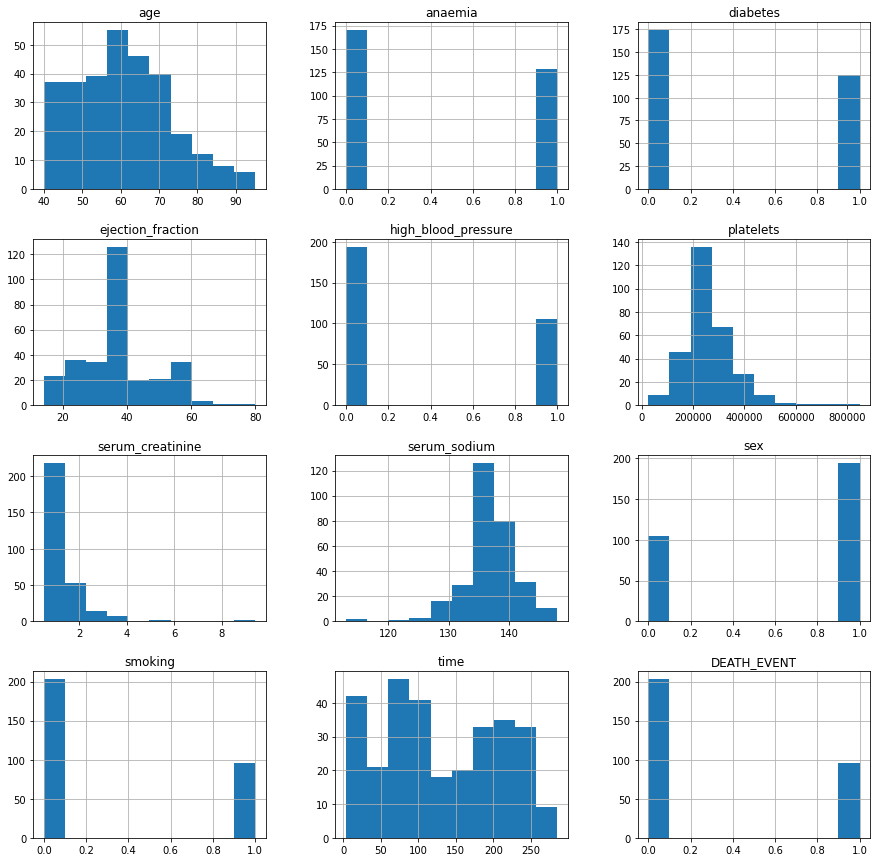

In [8]:
dataSet.hist(figsize = (15,15));

A continuación creamos una copia del dataset para manipular

In [60]:
newDataSet = dataSet.copy()

In [77]:
bins = []
for i in range(12):
    bins.append(40 + (i)*40/8)
print(bins)

[40.0, 45.0, 50.0, 55.0, 60.0, 65.0, 70.0, 75.0, 80.0, 85.0, 90.0, 95.0]


<function matplotlib.pyplot.show(close=None, block=None)>

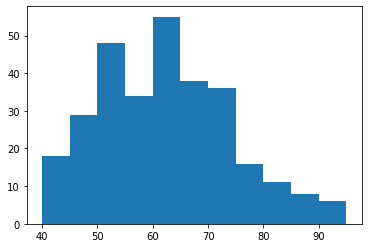

In [78]:
plt.hist(newDataSet['age'], bins)
plt.show

*Analisis del data set segun su resultado final*

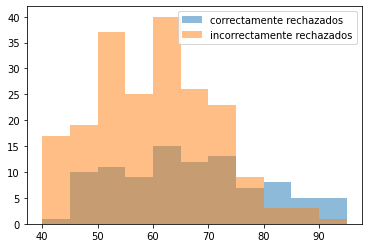

In [85]:
# separamos el dataset en dos segun si muere o no
deathDataSet = dataSet[dataSet['DEATH_EVENT'] == 1]
aliveDataSet = dataSet[dataSet['DEATH_EVENT'] == 0]
plt.hist(deathDataSet['age'], bins, alpha = 0.5, label = 'correctamente rechazados')
plt.hist(aliveDataSet['age'], bins, alpha = 0.5, label = 'incorrectamente rechazados')
plt.legend(loc = 'upper right')
plt.show()

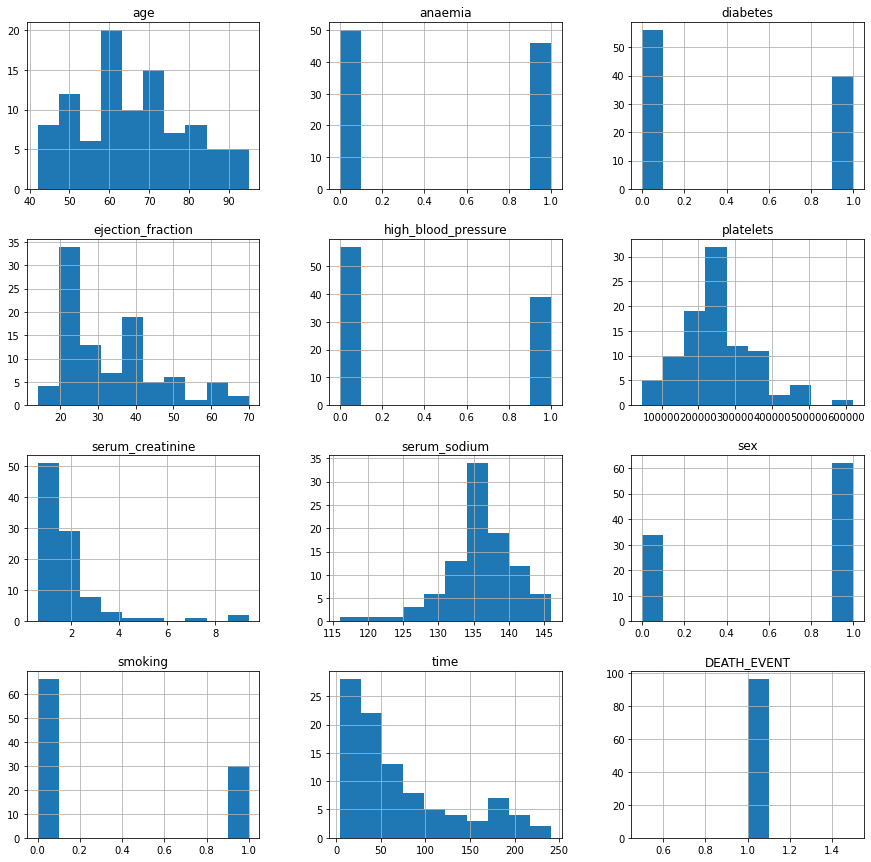

In [89]:
deathDataSet.hist(figsize = (15,15));

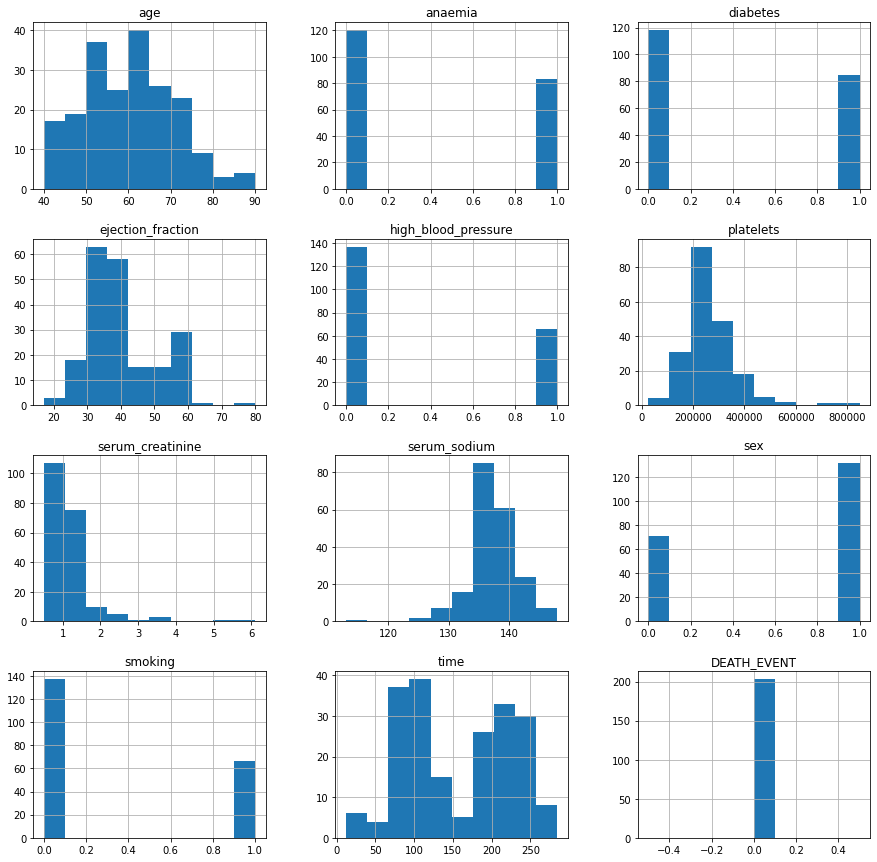

In [87]:
aliveDataSet.hist(figsize = (15,15));

In [93]:
deathDataSet.describe()

,age,anaemia,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,96.000000,96.000000,96.000000,96.000000,96.00000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.0
mean,65.215281,0.479167,0.416667,33.468750,0.40625,256381.044792,1.835833,135.375000,0.645833,0.312500,70.885417,1.0
std,13.214556,0.502188,0.495595,12.525303,0.49371,98525.682856,1.468562,5.001579,0.480771,0.465946,62.378281,0.0
min,42.000000,0.000000,0.000000,14.000000,0.00000,47000.000000,0.600000,116.000000,0.000000,0.000000,4.000000,1.0
25%,55.000000,0.000000,0.000000,25.000000,0.00000,197500.000000,1.075000,133.000000,0.000000,0.000000,25.500000,1.0
50%,65.000000,0.000000,0.000000,30.000000,0.00000,258500.000000,1.300000,135.500000,1.000000,0.000000,44.500000,1.0
75%,75.000000,1.000000,1.000000,38.000000,1.00000,311000.000000,1.900000,138.250000,1.000000,1.000000,102.250000,1.0
max,95.000000,1.000000,1.000000,70.000000,1.00000,621000.000000,9.400000,146.000000,1.000000,1.000000,241.000000,1.0


In [94]:
aliveDataSet.describe()

,age,anaemia,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.0
mean,58.761906,0.408867,0.418719,40.266010,0.325123,266657.489901,1.184877,137.216749,0.650246,0.325123,158.339901,0.0
std,10.637890,0.492840,0.494569,10.859963,0.469579,97531.202283,0.654083,3.982923,0.478071,0.469579,67.742872,0.0
min,40.000000,0.000000,0.000000,17.000000,0.000000,25100.000000,0.500000,113.000000,0.000000,0.000000,12.000000,0.0
25%,50.000000,0.000000,0.000000,35.000000,0.000000,219500.000000,0.900000,135.500000,0.000000,0.000000,95.000000,0.0
50%,60.000000,0.000000,0.000000,38.000000,0.000000,263000.000000,1.000000,137.000000,1.000000,0.000000,172.000000,0.0
75%,65.000000,1.000000,1.000000,45.000000,1.000000,302000.000000,1.200000,140.000000,1.000000,1.000000,213.000000,0.0
max,90.000000,1.000000,1.000000,80.000000,1.000000,850000.000000,6.100000,148.000000,1.000000,1.000000,285.000000,0.0


Vamos a ver si existe correlacion directa entre muerte y alguna variable

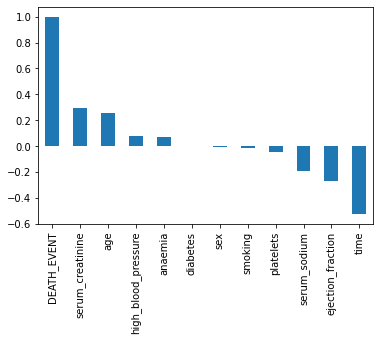

In [91]:
dataSet.corr()['DEATH_EVENT'].sort_values(ascending = False).plot(kind = 'bar');

Vemos correlacion entre todas las variables

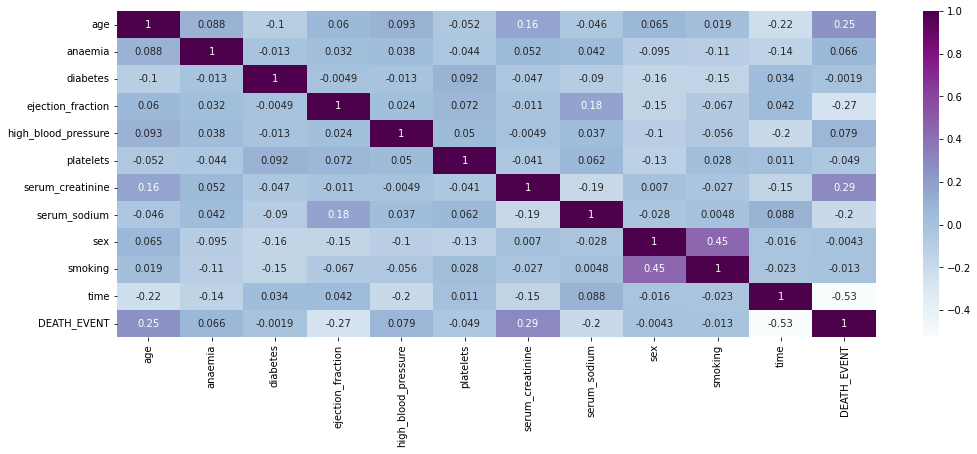

In [92]:
plt.figure(figsize = (17,6))
sns.heatmap(dataSet.corr(), annot = True, cmap="BuPu")
plt.show()

In [ ]:
## sacamos columnas que no aportan al estudio ni son razones de falla cardiaca
dataSet.drop(['creatinine_phosphokinase'], axis=1, inplace = True)

In [ ]:
dataSet.describe()

In [21]:
## Genero un dataframe con los aspectos mas importantes segun el paper
mostRelevantData = dataSet[['ejection_fraction', 'serum_creatinine', 'DEATH_EVENT']].copy()

In [22]:
mostRelevantData.head()

,ejection_fraction,serum_creatinine,DEATH_EVENT
0,20,1.9,1
1,38,1.1,1
2,20,1.3,1
3,20,1.9,1
4,20,2.7,1


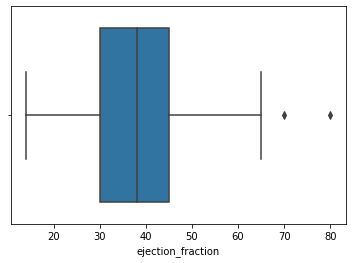

In [23]:
fig, ax = plt.subplots()
sns.boxplot(x = mostRelevantData['ejection_fraction'])

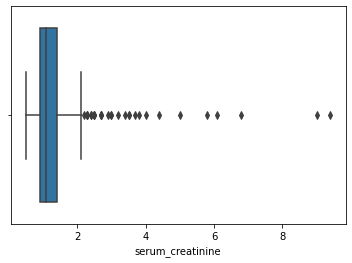

In [24]:
fig, ax = plt.subplots()
sns.boxplot(x = mostRelevantData['serum_creatinine'])

In [25]:
mostRelevantData.describe()

,ejection_fraction,serum_creatinine,DEATH_EVENT
count,299.000000,299.00000,299.00000
mean,38.083612,1.39388,0.32107
std,11.834841,1.03451,0.46767
min,14.000000,0.50000,0.00000
25%,30.000000,0.90000,0.00000
50%,38.000000,1.10000,0.00000
75%,45.000000,1.40000,1.00000
max,80.000000,9.40000,1.00000


In [26]:
Q1 = mostRelevantData['ejection_fraction'].quantile(0.25)
Q3 = mostRelevantData['ejection_fraction'].quantile(0.75)
IQR = Q3 - Q1   
lower = Q1 - 1.5*IQR
higher = Q3 + 1.5*IQR
((mostRelevantData < lower) | (mostRelevantData > higher)).sum()

ejection_fraction      2
serum_creatinine     297
DEATH_EVENT          299
dtype: int64

In [27]:
mostRelevantData = mostRelevantData.loc[(mostRelevantData['ejection_fraction'] >= lower) & (mostRelevantData['ejection_fraction'] <= higher)]
mostRelevantData.describe()

,ejection_fraction,serum_creatinine,DEATH_EVENT
count,297.000000,297.000000,297.000000
mean,37.835017,1.368990,0.319865
std,11.470426,0.938731,0.467211
min,14.000000,0.500000,0.000000
25%,30.000000,0.900000,0.000000
50%,38.000000,1.100000,0.000000
75%,45.000000,1.400000,1.000000
max,65.000000,9.400000,1.000000


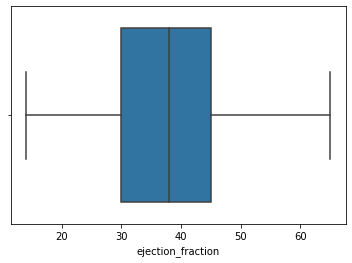

In [28]:
fig, ax = plt.subplots()
sns.boxplot(x = mostRelevantData['ejection_fraction'])

c:\Users\elfee\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='ejection_fraction', ylabel='Density'>

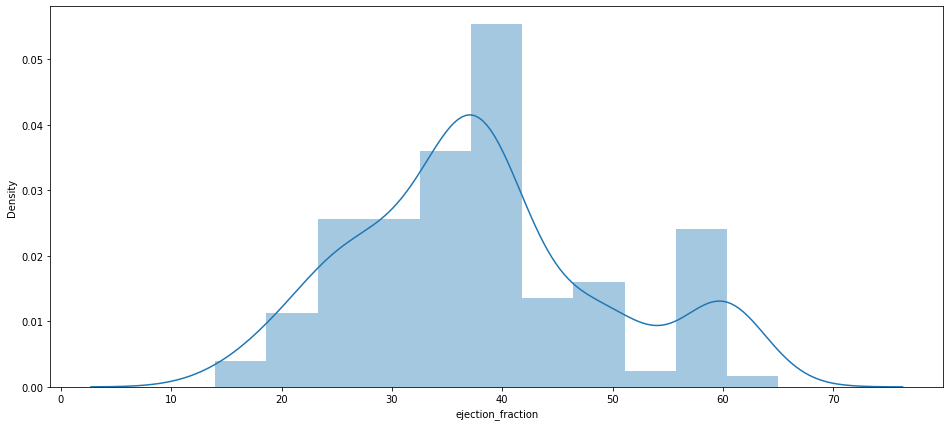

In [50]:
fig, ax = plt.subplots(figsize = (16,7))
sns.distplot(mostRelevantData.iloc[:, 0])

c:\Users\elfee\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='ejection_fraction', ylabel='Density'>

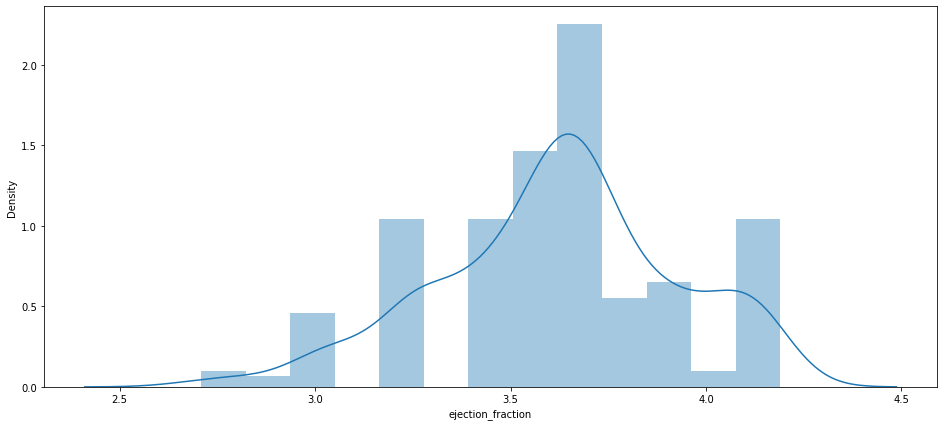

In [52]:
# LOGARITMICO
fig, ax = plt.subplots(figsize=(16,7))
sns.distplot(np.log1p(mostRelevantData.iloc[:,0]))

In [29]:
Q1 = mostRelevantData['serum_creatinine'].quantile(0.25)
Q3 = mostRelevantData['serum_creatinine'].quantile(0.75)
IQR = Q3 - Q1   
lower = Q1 - 1.5*IQR
higher = Q3 + 1.5*IQR
((mostRelevantData < lower) | (mostRelevantData > higher)).sum()

ejection_fraction    297
serum_creatinine      28
DEATH_EVENT          202
dtype: int64

In [30]:
mostRelevantData = mostRelevantData.loc[(mostRelevantData['serum_creatinine'] >= lower) & (mostRelevantData['serum_creatinine'] <= higher)]
mostRelevantData.describe()

,ejection_fraction,serum_creatinine,DEATH_EVENT
count,269.000000,269.000000,269.000000
mean,38.066914,1.136022,0.289963
std,11.501589,0.339010,0.454591
min,14.000000,0.500000,0.000000
25%,30.000000,0.900000,0.000000
50%,38.000000,1.100000,0.000000
75%,45.000000,1.300000,1.000000
max,65.000000,2.100000,1.000000


<AxesSubplot:xlabel='serum_creatinine'>

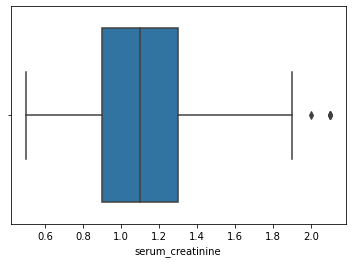

In [48]:
fig, ax = plt.subplots()
sns.boxplot(x = mostRelevantData['serum_creatinine'])

c:\Users\elfee\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='serum_creatinine', ylabel='Density'>

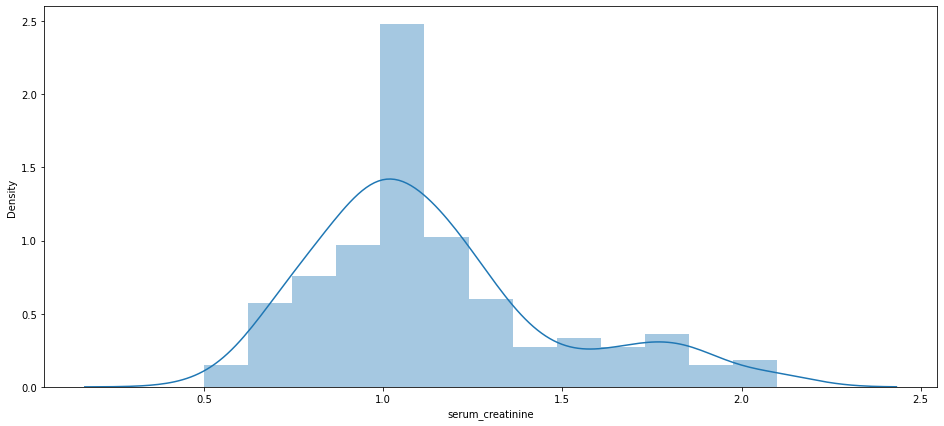

In [53]:
# LOGARITMICO
fig, ax = plt.subplots(figsize = (16,7))
sns.distplot(mostRelevantData.iloc[:, 1])

***Logaritmic***

c:\Users\elfee\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='ejection_fraction', ylabel='Density'>

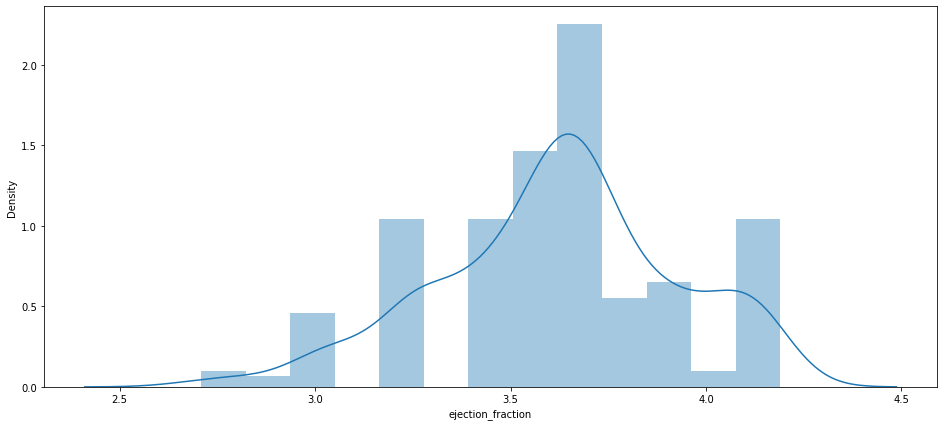

In [51]:
fig, ax = plt.subplots(figsize=(16,7))
sns.distplot(np.log1p(mostRelevantData.iloc[:,0]))

***Random Forest:***

In [54]:
X = mostRelevantData.drop(['DEATH_EVENT'], axis = 1)
Y = mostRelevantData['DEATH_EVENT']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=5)

In [55]:
Tree_model = RandomForestClassifier(n_estimators=19, random_state=2016, min_samples_leaf=8)
Tree_model.fit(X_train, Y_train)
Tree_model.score(X_test, Y_test)

0.8703703703703703

In [56]:
X_norm = np.log1p(mostRelevantData.iloc[:, :-1])
X_norm.head()

,ejection_fraction,serum_creatinine
0,3.044522,1.064711
1,3.663562,0.741937
2,3.044522,0.832909
3,3.044522,1.064711
5,3.713572,1.131402


In [ ]:
y_pred = Tree_model.predict(X_test)
matrix = confusion_matrix(Y_test, y_pred)

##plot_consufion_matrix(config_mat=matriz, figsize=(6,6), show_normed=False)
##plt.tight_layout()

import seaborn as sns

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

*Manipulando el dataframe "dataSet"*

In [ ]:
#for i in range(len(dataSet))